In [4]:
import numpy as np
import pandas as pd
import mplfinance as mpf
import os
from glob import glob
import matplotlib.pyplot as plt

%matplotlib inline

#import talib as ta # conda activate cryt310
from matplotlib.ticker import AutoMinorLocator
import time
from itertools import zip_longest
from IPython.display import Javascript
import datetime
import schedule
import json,requests 

%load_ext autoreload
%autoreload 2

tickerpair="ETCUSDT" #GBPUSDT #LTCUSDT #ETHUSDT #BTCUSDT
#tickerpair="BNBUSDT" #BNBUSDT #AUDUSDT #XMRUSDT
intervals=['1m','3m','5m','15m','30m','1h','2h','3h','4h','6h','8h','12h','1d','3d','1w','1Month']

# define constants
tickerpair="ETCUSDT"
interval="1m"
from aver6_funcs import get_data
import pickle,tqdm
from concurrent.futures import ThreadPoolExecutor
import concurrent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
with open("9_0_subset_symbols_24hrchange.pkl","rb") as f:
    subset_symbols = pickle.load(f)[:45] # select the top 50 symbols
len(subset_symbols),subset_symbols[1]

(45, 'XRP')

In [6]:
top50symbols_usdt = [s+"USDT" for s in subset_symbols]

In [7]:
dfmpl_list_list = []
for iterr in tqdm.tqdm(range(50)):
    with open(f"2_3_1_analysisdata/2_3_1_dfmpl_list_{iterr:05d}.pkl","rb")as f:
        dfmpl_list2 = pickle.load(f)
    dfmpl_list = [ d for d in dfmpl_list2 if d[1] in top50symbols_usdt]
    dfmpl_list_list.append( dfmpl_list.copy())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 48.21it/s]


In [8]:
%%time
for symm in tqdm.tqdm(subset_symbols):
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    if not all(np.diff(df__.index,2).astype(float)==0):
        print(symm)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.83it/s]

CPU times: total: 438 ms
Wall time: 828 ms


# concat the dfs, store into a list of dfs, also store a list of corresponding symbols

In [9]:
dfmpl_list = []

for idd,symm in enumerate(tqdm.tqdm(subset_symbols[:45])):
    #if idd<110:continue
    if "USD" in symm: continue
    symm = symm+"USDT"
    df_  = pd.concat([ df for dfll in dfmpl_list_list[::-1] for df,sym,idd in dfll if sym==symm])
    
    idx = np.unique( df_.index.values, return_index = True )[1]
    df__ = df_.iloc[idx]
    dfmpl_list.append( (df__.copy(),symm,idd) ) 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 71.39it/s]


In [11]:
dfmpl,symm,idd = dfmpl_list[0]
dfmpl,symm,idd,len(dfmpl_list)

(                         Open      High       Low     Close    Volume
 Date                                                                 
 2023-12-10 20:14:00  43749.82  43749.82  43749.00  43749.01  13.18012
 2023-12-10 20:15:00  43749.01  43756.24  43749.00  43756.24  23.50066
 2023-12-10 20:16:00  43756.23  43770.72  43756.23  43770.71  25.12115
 2023-12-10 20:17:00  43770.71  43774.00  43770.71  43773.99   7.61446
 2023-12-10 20:18:00  43774.00  43777.36  43773.99  43777.36   8.99726
 ...                       ...       ...       ...       ...       ...
 2024-01-14 13:29:00  42737.46  42740.00  42724.00  42739.99   7.93961
 2024-01-14 13:30:00  42740.00  42746.00  42739.99  42746.00   6.90809
 2024-01-14 13:31:00  42745.99  42746.00  42732.24  42732.24   6.75295
 2024-01-14 13:32:00  42732.25  42737.25  42732.24  42737.24   5.12337
 2024-01-14 13:33:00  42737.25  42737.25  42735.20  42735.21   5.44117
 
 [50000 rows x 5 columns],
 'BTCUSDT',
 0,
 43)

In [12]:
v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
vol = (dfmpl.Volume*dfmpl.Open).values

In [13]:
vol

array([ 576627.8775784, 1028130.6093466, 1099206.8172645, ...,
        288661.5331705,  218933.1276825,  232540.6425825])

In [14]:
np.percentile(vol,99)

9591754.377066297

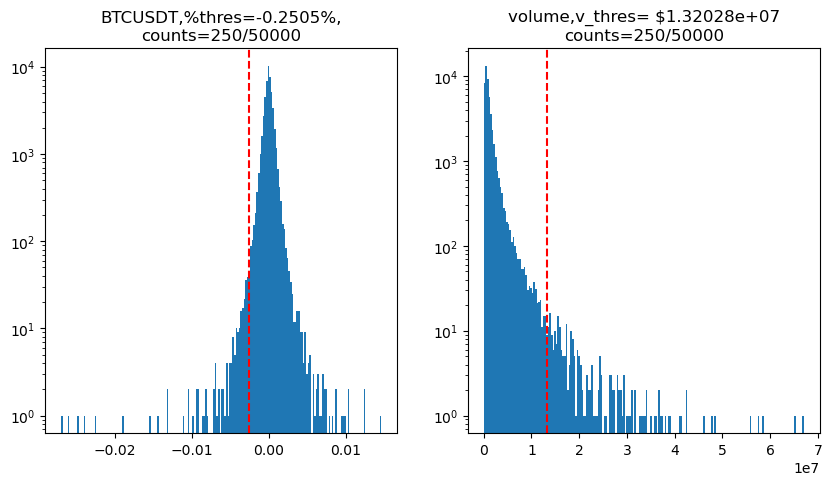

In [15]:
fig,axx=plt.subplots(1,2,figsize=(10,5))
ax=axx[0]
#percentile_threshold = np.percentile(v,99.9)
percentile_threshold = np.percentile(v,0.5)
ax.hist(v,bins=200);
ax.axvline(percentile_threshold,ls="--",c="r")
ax.set_title(f"{symm},%thres={percentile_threshold:.4%},\ncounts={sum(v<percentile_threshold)}/{len(v)}")
ax.set_yscale("log")
ax=axx[1]
ax.hist(vol,bins=200);
vol_threshold = np.percentile(vol,99.5)
ax.axvline(vol_threshold,ls="--",c="r")
ax.set_title(f"volume,v_thres= ${vol_threshold:3,g}\ncounts={sum(vol>vol_threshold)}/{len(vol)}")
ax.set_yscale("log")

# when price falls twice in a row, 

In [16]:
paramsWin = (-0.00689655,-0.00862069,1000000,2689655) # high%win params
paramsLowSD = (-0.00689655,-0.00172414,2689655,4379310) #lowSD 
#paramsWin = (-0.0049655,0.3,2689655,4379310) #testing

In [17]:
import random

In [18]:
%%time 
collated_data_list = []
all_locs = [] 
    
for dfmpl, symb, _ in tqdm.tqdm(dfmpl_list):
    def validate_df(loc, df_v, v0_thres, v1_thres):
        v0 = df_v[loc, 0] * df_v[loc, 4]
        v1 = df_v[loc + 1, 0] * df_v[loc + 1, 4]
        return v0 > v0_thres and v1 > v1_thres
    v = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).values
#     threshold1 = -0.0082#np.percentile(v,1)
#     threshold2 = -0.005# np.percentile(v,2)
#     v0_thres = np.percentile(vol,99)
#     v1_thres = np.percentile(vol,98)
    threshold1,threshold2,v0_thres,v1_thres = paramsWin
    df_v = dfmpl.values
    changes = (df_v[:, 3] - df_v[:, 0]) / df_v[:, 0] #open high low close volume
    a4_1 = np.logical_and(changes[1:] < threshold1, changes[:-1] < threshold2)
    locs = np.where(a4_1)[0]
    if locs.size == 0: continue
    chosen_locs = [loc for loc in locs if validate_df(loc, df_v, v0_thres, v1_thres)and loc<(190000-5)]
    if len(chosen_locs)==0:continue
    #[trade_locs.append(f"{loc}_{symb}") for loc in chosen_locs]
    collated_data = np.asarray([changes[loc:loc + 5] for loc in chosen_locs])
    [all_locs.append(loc)for loc in chosen_locs]
    collated_data_list.append(collated_data) 
                
collated_data = np.vstack(collated_data_list)
collated_data.shape

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 399.49it/s]

CPU times: total: 46.9 ms
Wall time: 118 ms


(28, 5)

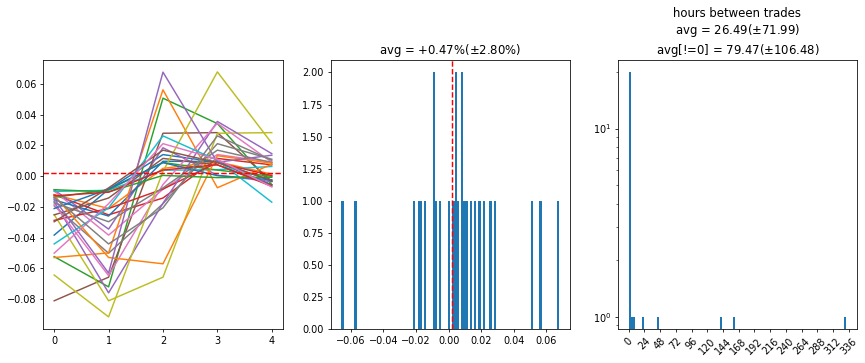

In [19]:
fig,axx=plt.subplots(1,3,figsize=(15,5),dpi=70)
ax=axx[0]
ax.plot(collated_data.T[:,random.sample(range(collated_data.shape[0]),min(200,collated_data.shape[0]))])
ax.axhline(0.002,ls="--",c="r")
ax=axx[1]
ax.hist(collated_data[:,2],bins=100);
ax.axvline(0.002,ls="--",c="r")
ax.set_title(f"avg = {np.mean(collated_data[:,2]):+.2%}($\pm${np.std(collated_data[:,2]):.2%})")
ax=axx[2]
hours_between_trades=np.diff(sorted(all_locs))/60
ax.hist(hours_between_trades,bins=100);
strr="hours between trades"
strr+=f"\navg = {np.mean(hours_between_trades):.2f}($\pm${np.std(hours_between_trades):.2f})"
strr+=f"\navg[!=0] = {np.mean(hours_between_trades[hours_between_trades!=0]):.2f}($\pm${np.std(hours_between_trades[hours_between_trades!=0]):.2f})"
ax.set_title(strr)
ax.set_yscale("log")
ax.set_xticks(np.arange(0,max(hours_between_trades)+24,24))
ax.set_xticklabels([f"{n:.0f}" for n in np.arange(0,max(hours_between_trades)+24,24)],rotation=45);

In [20]:
dfmpl,symm,idd = dfmpl_list[0]
dfmpl,symm,idd,len(dfmpl_list)

(                         Open      High       Low     Close    Volume
 Date                                                                 
 2023-12-10 20:14:00  43749.82  43749.82  43749.00  43749.01  13.18012
 2023-12-10 20:15:00  43749.01  43756.24  43749.00  43756.24  23.50066
 2023-12-10 20:16:00  43756.23  43770.72  43756.23  43770.71  25.12115
 2023-12-10 20:17:00  43770.71  43774.00  43770.71  43773.99   7.61446
 2023-12-10 20:18:00  43774.00  43777.36  43773.99  43777.36   8.99726
 ...                       ...       ...       ...       ...       ...
 2024-01-14 13:29:00  42737.46  42740.00  42724.00  42739.99   7.93961
 2024-01-14 13:30:00  42740.00  42746.00  42739.99  42746.00   6.90809
 2024-01-14 13:31:00  42745.99  42746.00  42732.24  42732.24   6.75295
 2024-01-14 13:32:00  42732.25  42737.25  42732.24  42737.24   5.12337
 2024-01-14 13:33:00  42737.25  42737.25  42735.20  42735.21   5.44117
 
 [50000 rows x 5 columns],
 'BTCUSDT',
 0,
 43)

C:\Users\aatan\anaconda3\envs\cryt310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


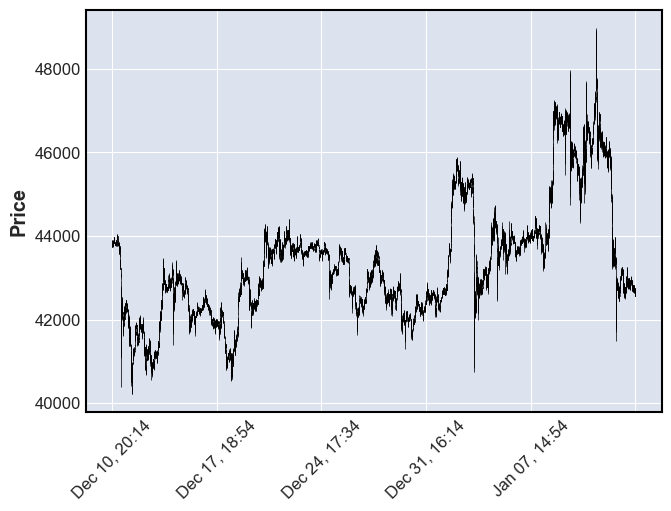

In [21]:
mpf.plot(dfmpl)

In [22]:
import pandas_ta as ta
import talib
from talib import MA_Type

In [23]:
def find_ones_with_min_distance(data, min_distance=1):
    ones_positions = []
    last_one = -min_distance - 1

    for i, value in enumerate(data):
        if value == 1:
            if i - last_one >= min_distance:
                ones_positions.append(i)
                last_one = i

    return ones_positions
 


In [24]:
%%time
upper, middle, lower = talib.BBANDS(dfmpl.Close,timeperiod=50, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl.Close,timeperiod=50)
change = ((dfmpl.Close-dfmpl.Open)/dfmpl.Open).rolling(4).mean()
momentum = talib.MOM(dfmpl.Close,timeperiod=40)
momentum_rolling30 = momentum.rolling(30).mean()
momentum_rolling40 = momentum.rolling(40).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl.Close,timeperiod=30,fastk_period=25,fastd_period=15)

CPU times: total: 0 ns
Wall time: 16.1 ms


In [25]:
%%time
binary_condition = (momentum<-450) & (momentum_rolling30<-250) & (momentum_rolling30.shift(30)<50)
potential_candidates = np.where(binary_condition)[0]
#potential_candidates = np.where(change<-0.002)[0]
#potential_candidates

CPU times: total: 0 ns
Wall time: 2.01 ms


In [26]:
potential_candidates = find_ones_with_min_distance(binary_condition,40)

In [27]:
dd_ = (dfmpl.iloc[-1].name-dfmpl.iloc[0].name).total_seconds()/3600/24
f"{dd_/len(potential_candidates):.4f} days per trade, {len(potential_candidates)} trades in {dd_:.0f} days"

'1.1574 days per trade, 30 trades in 35 days'

In [36]:
inddex_of_frame

3223

In [45]:
df_5min = dfmpl.resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})

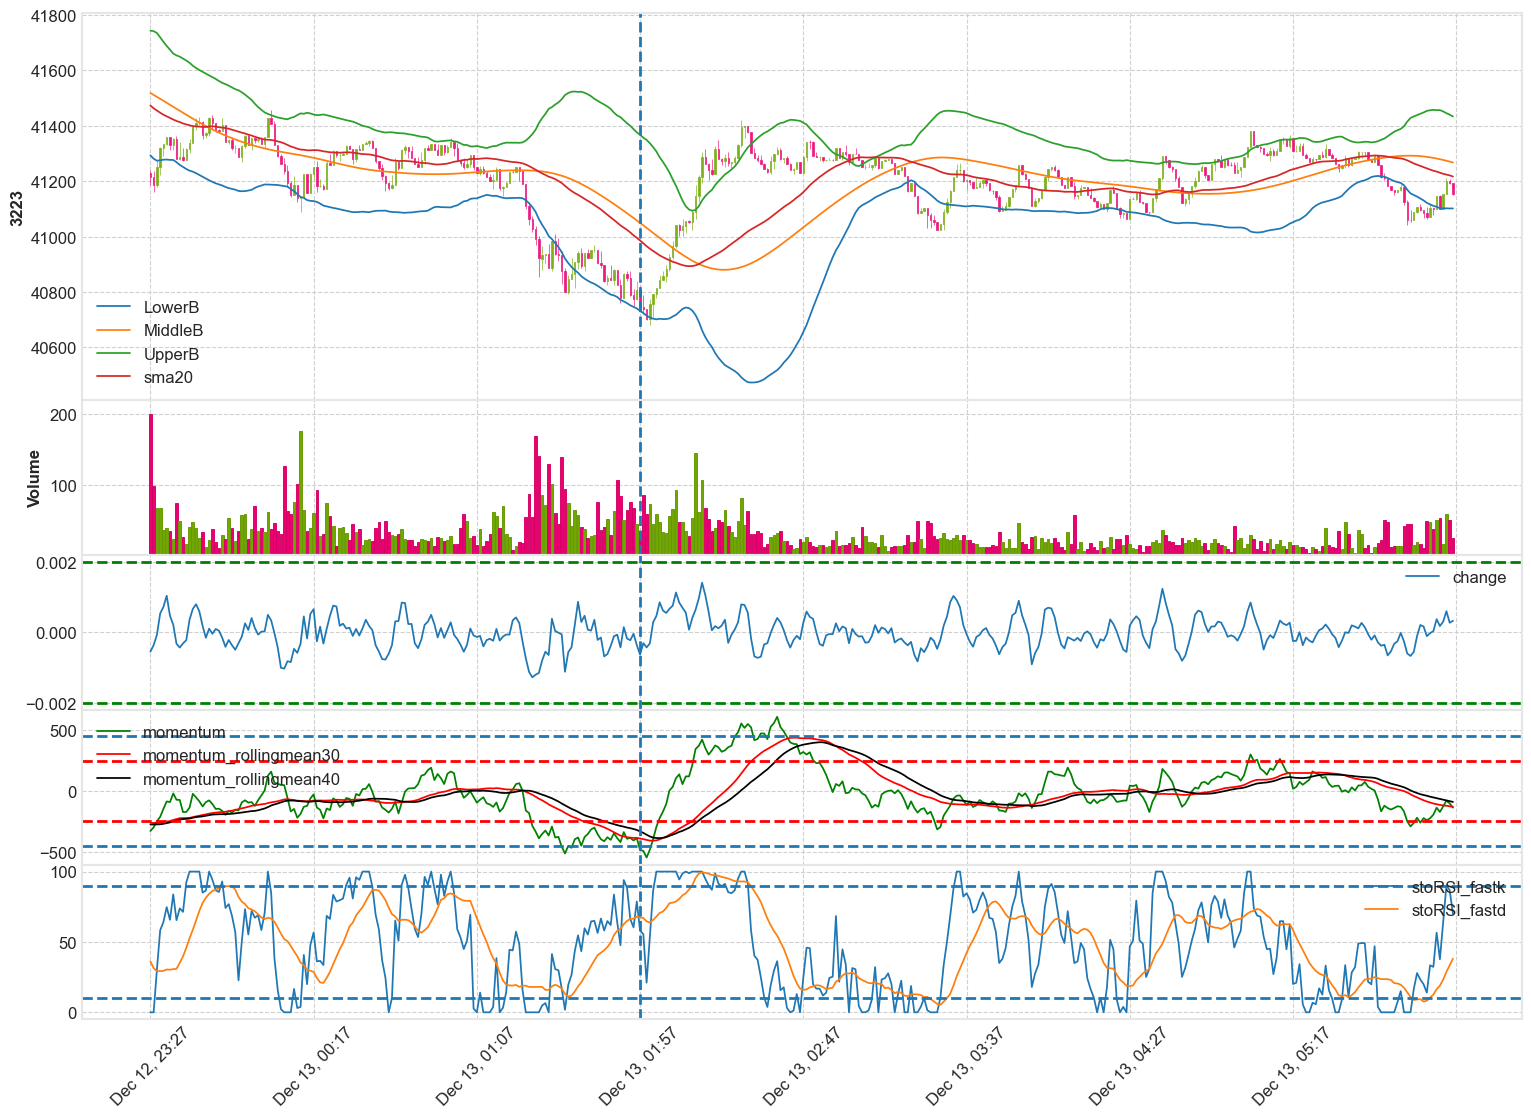

CPU times: total: 2.31 s
Wall time: 3.83 s


In [35]:
%%time
selected_indexs=potential_candidates
for inddex_of_frame in selected_indexs[3:4]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    my_vlines=[dfmpl.iloc[inddex_of_frame].name]
    my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper.iloc[lowerlim:upperlim],label="UpperB"),
             mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
             mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
             mpf.make_addplot(momentum.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
             mpf.make_addplot(momentum_rolling30.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean30",color="r",secondary_y=False),
             mpf.make_addplot(momentum_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean40",color="k",secondary_y=False),
             mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd")
             ]
    fig, axlist = mpf.plot(dfmpl.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2.5,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for axi,ax in enumerate(axlist):
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--')
        if axi==4:
            ax.axhline(-0.002, linestyle='--',c="g")
            ax.axhline(0.002, linestyle='--',c="g")
        if axi==6:
            ax.axhline(-450, linestyle='--')
            ax.axhline(450, linestyle='--')
            ax.axhline(-250, linestyle='--',c="r")
            ax.axhline(250, linestyle='--',c="r")
        if axi==8:
            ax.axhline(90, linestyle='--')
            ax.axhline(10, linestyle='--')
    mpf.show()

In [50]:
df_1min =dfmpl.iloc[:1000]
df_5min = df_1min.resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})

In [ ]:
df_1min =dfmpl.iloc[:1000]
df_5min = df_1min.resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})

In [62]:
%%time

dfmpl_temp = dfmpl.copy().resample('5T').agg({'Open': 'first', 
                                      'High': 'max', 
                                      'Low': 'min', 
                                      'Close': 'last',
                                      'Volume': 'sum'})
time_scale = 5
upper, middle, lower = talib.BBANDS(dfmpl_temp.Close,timeperiod=10*time_scale, matype=MA_Type.T3)
sma20 =  talib.SMA(dfmpl_temp.Close,timeperiod=10*time_scale)
change = ((dfmpl_temp.Close-dfmpl_temp.Open)/dfmpl_temp.Open).rolling(4).mean()
momentum = talib.MOM(dfmpl_temp.Close,timeperiod=8*time_scale)
momentum_rolling30 = momentum.rolling(6*time_scale).mean()
momentum_rolling40 = momentum.rolling(8*time_scale).mean()
stoRSI_fastk,stoRSI_fastd = talib.STOCHRSI(dfmpl_temp.Close,timeperiod=6*time_scale,fastk_period=5*time_scale,fastd_period=3*time_scale)



CPU times: total: 0 ns
Wall time: 15.6 ms


In [64]:
binary_condition = (momentum<-1800) & (momentum_rolling30<-250) & (momentum_rolling30.shift(30)<50)
potential_candidates = find_ones_with_min_distance(binary_condition,40)
len(potential_candidates)

4

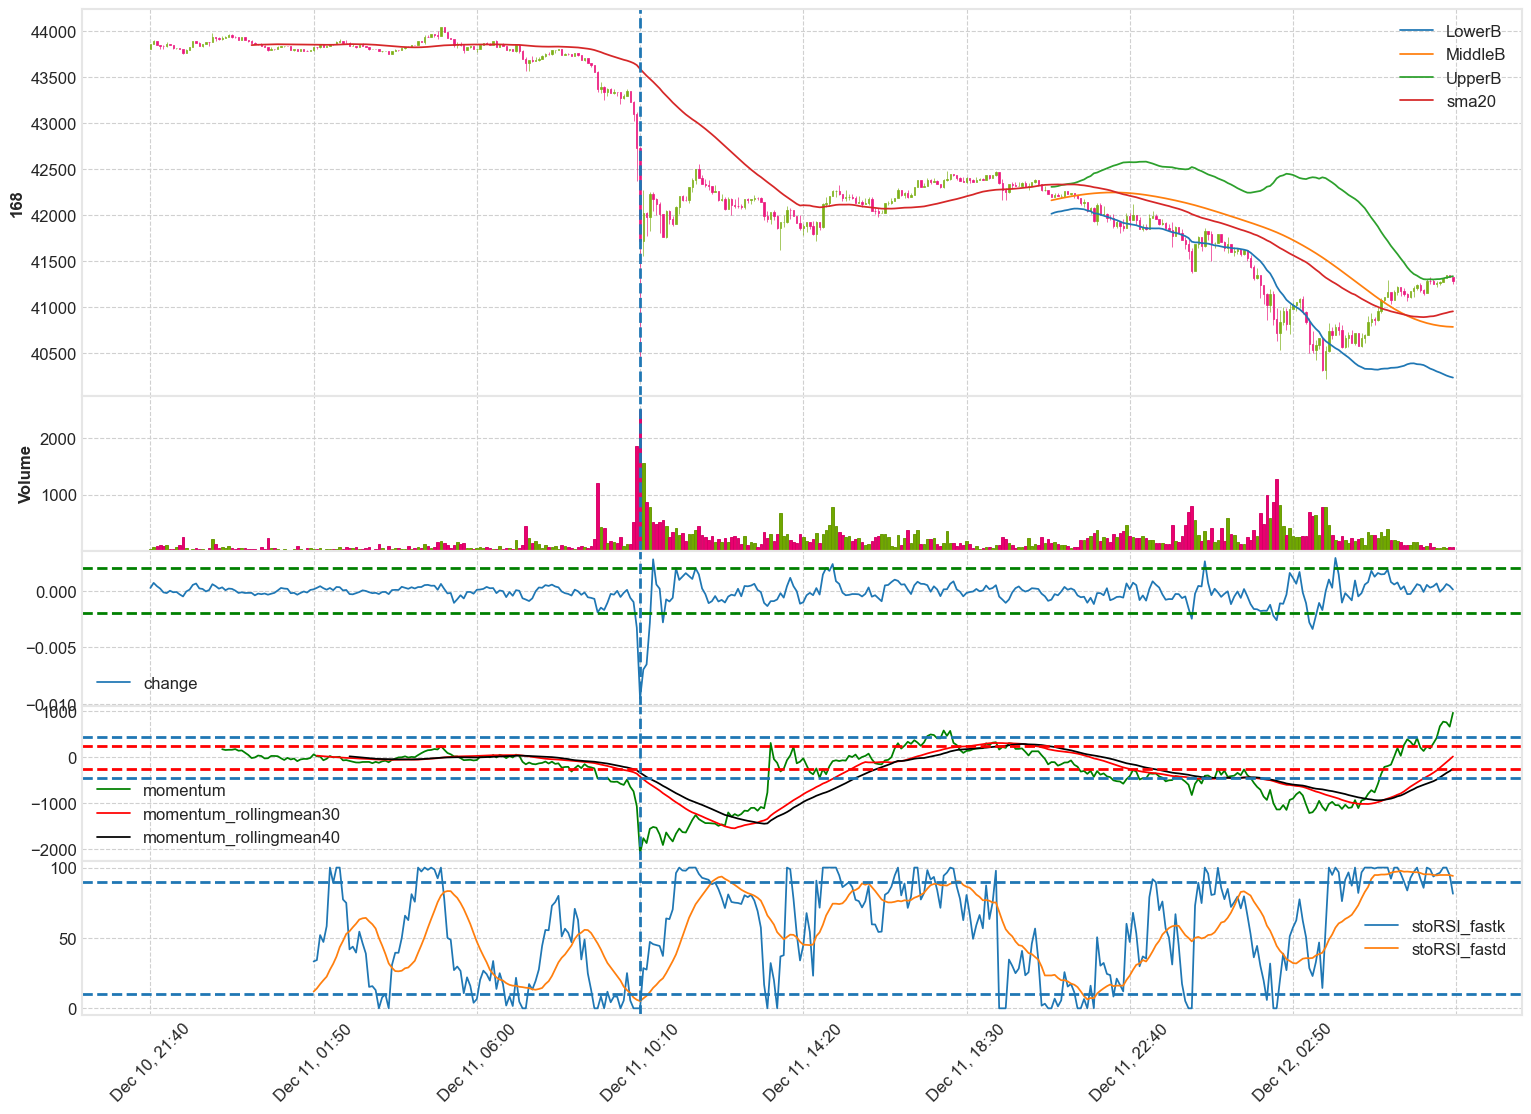

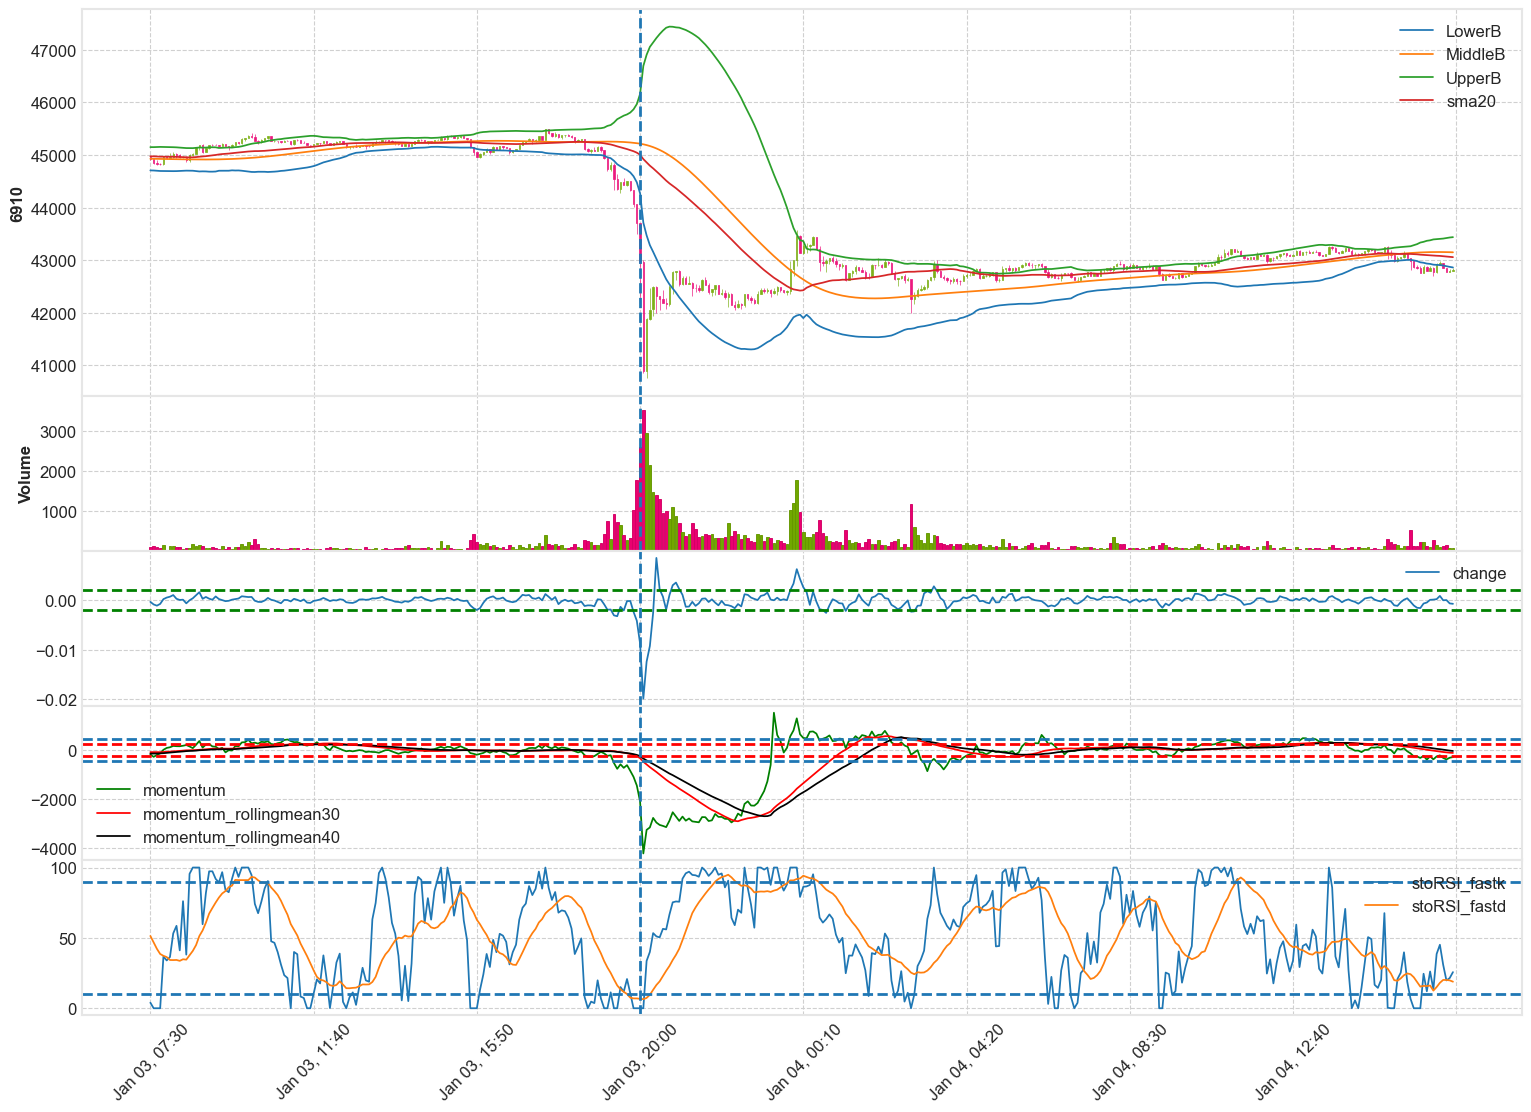

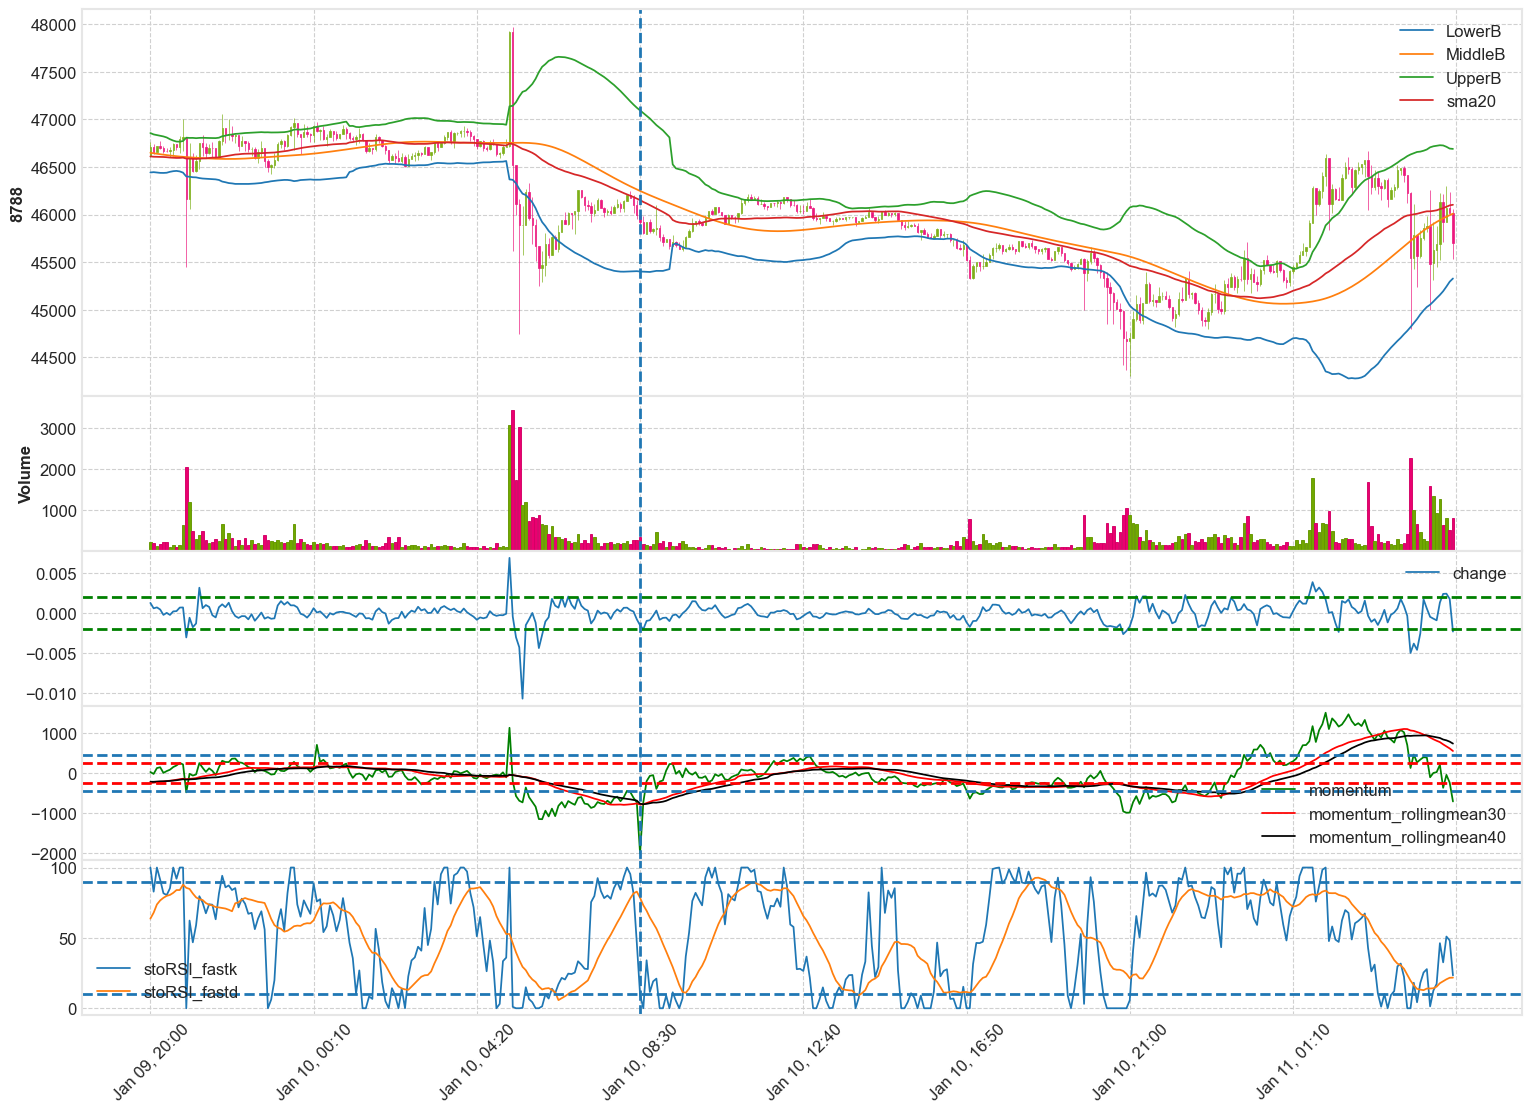

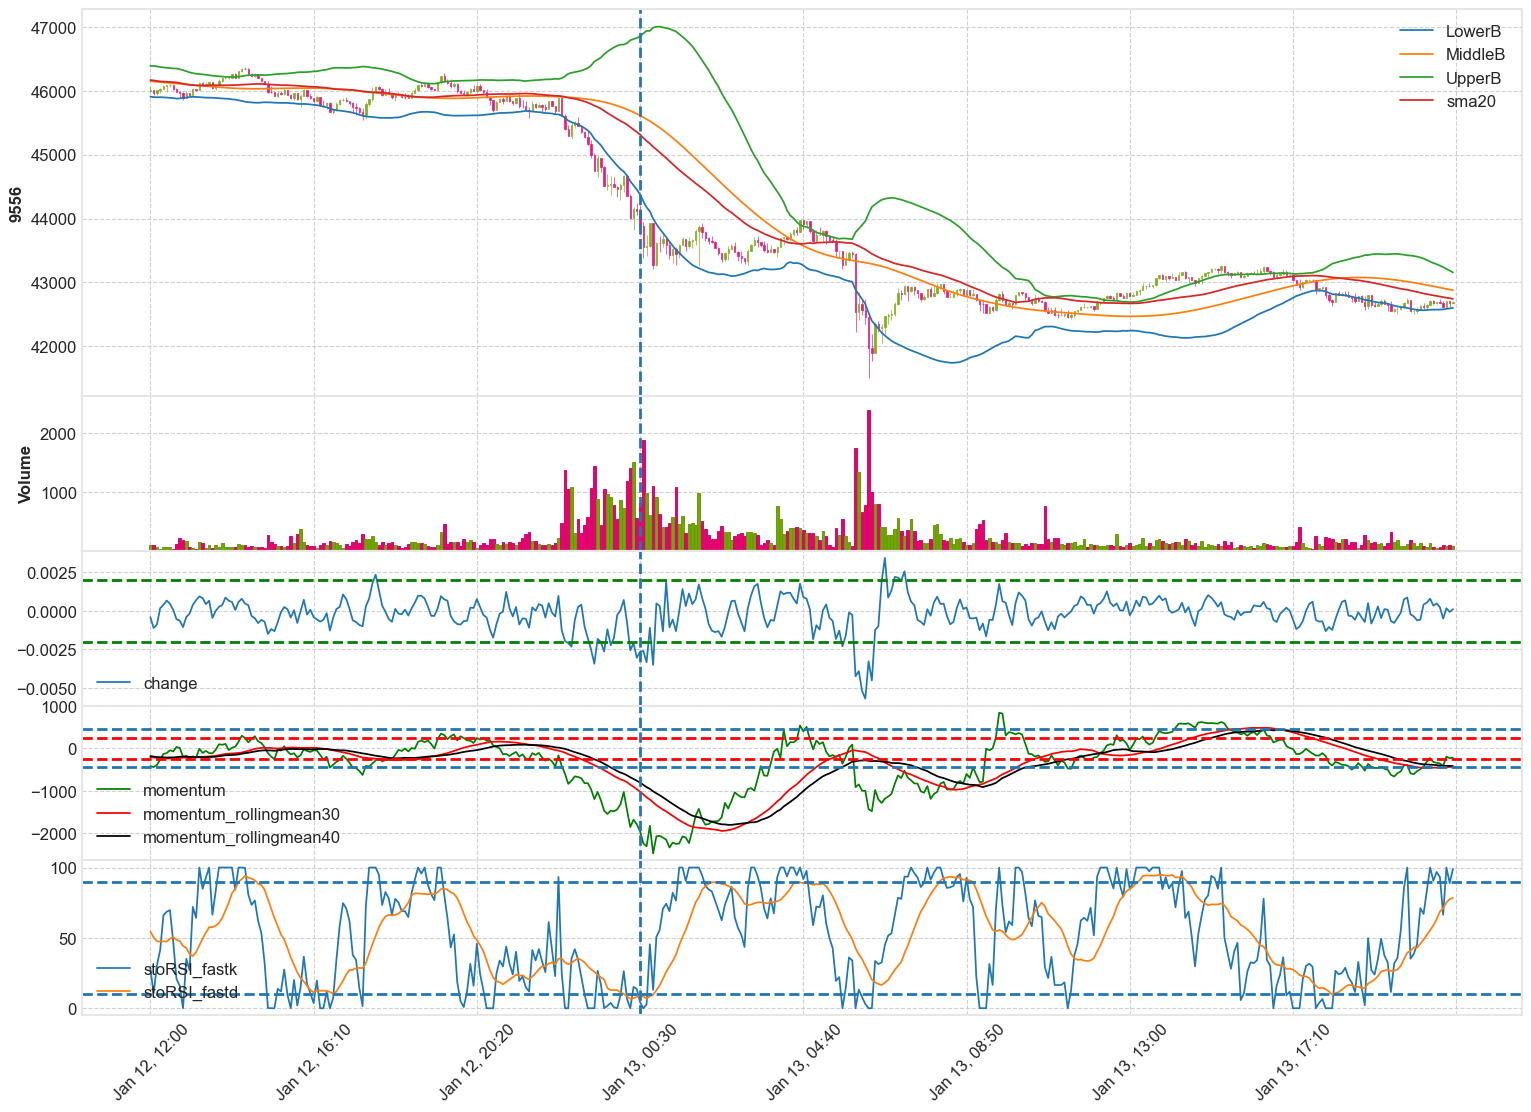

CPU times: total: 9.58 s
Wall time: 15.4 s


In [65]:
%%time
selected_indexs=potential_candidates
for inddex_of_frame in selected_indexs[:]:
    #vlines=dict(vlines=[dfmpl.iloc[inddex_of_frame].name])
    my_vlines=[dfmpl_temp.iloc[inddex_of_frame].name]
    my_vlines=[150]
    lowerlim = inddex_of_frame-150
    upperlim = lowerlim+400
    apdict = [mpf.make_addplot(lower.iloc[lowerlim:upperlim],label="LowerB"),
              mpf.make_addplot(middle.iloc[lowerlim:upperlim],label="MiddleB"),
              mpf.make_addplot(upper.iloc[lowerlim:upperlim],label="UpperB"),
             mpf.make_addplot(sma20.iloc[lowerlim:upperlim],label="sma20"),
             mpf.make_addplot(change.iloc[lowerlim:upperlim],panel=2,label="change"),
             mpf.make_addplot(momentum.iloc[lowerlim:upperlim],panel=3,label="momentum",color="g"),
             mpf.make_addplot(momentum_rolling30.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean30",color="r",secondary_y=False),
             mpf.make_addplot(momentum_rolling40.iloc[lowerlim:upperlim],panel=3,label="momentum_rollingmean40",color="k",secondary_y=False),
             mpf.make_addplot(stoRSI_fastk.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastk"),
              mpf.make_addplot(stoRSI_fastd.iloc[lowerlim:upperlim],panel=4,label="stoRSI_fastd")
             ]
    fig, axlist = mpf.plot(dfmpl_temp.iloc[lowerlim:upperlim],type='candle',volume=True,addplot=apdict,style="binance",
             warn_too_much_data=5000000,figscale=2.5,ylabel=f"{inddex_of_frame}",
            #vlines=my_vlines,
                           returnfig=True
                       )
             #savefig=f'2_3_0_figures/testsave_{inddex_of_frame}.png')
    for axi,ax in enumerate(axlist):
        for vline in my_vlines:
            ax.axvline(x=vline, linestyle='--')
        if axi==4:
            ax.axhline(-0.002, linestyle='--',c="g")
            ax.axhline(0.002, linestyle='--',c="g")
        if axi==6:
            ax.axhline(-450, linestyle='--')
            ax.axhline(450, linestyle='--')
            ax.axhline(-250, linestyle='--',c="r")
            ax.axhline(250, linestyle='--',c="r")
        if axi==8:
            ax.axhline(90, linestyle='--')
            ax.axhline(10, linestyle='--')
    mpf.show()

In [26]:
#from plotting import plot_profits

In [27]:
#plot_profits(collated_data[:,2])